In [15]:
# import libraries
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from decimal import Decimal
import time
import matplotlib.pyplot as plt
import time
import matplotlib.pyplot as plt
from balancerv2cad.WeightedPool import WeightedMath

# Simulator Class

In [16]:
class simulatorClass:
    def __init__(self,datasets):
        # Initialize instance variables to store state
        self.wstEthInCollateral = 0
        self.totalLoanedCrvUsd = 0
        self.datasets = datasets
        self.stakes = []
        self._process_dates()

## Utility Functions
    def upscaleTo18Decimals(self,amount):
      return amount * 10**18


    def downscaleFrom18Decimals(self,amount):
      return amount / 10**18


    def upscaleUsdc(self,amount):
      return amount * 10**6


    def downscaleUsdc(self,amount):
      return amount / 10**6


    def decimals18ToUsdcDecmials(self,amount):
      return amount / 10**12


    def usdcDecimalsto18Decimals(self,amount):
      return amount * 10**12



    def create_loan(self, dateToBorrow, collateral=1, current_debt=0):
        """Simulates creating a loan by depositing wstETH and borrowing crvUSD."""
        self.wstEthInCollateral += collateral
        print(
            "Added wstETH as collateral to create loan. Amount of wstETH:",
            self.downscaleFrom18Decimals(collateral),
        )
        print("Total Collateral:", self.downscaleFrom18Decimals(self.wstEthInCollateral))

        # Filter the max borrowable dataframe for the given date and convert to integer
        crvUsdLoanAmount = int(self.datasets["maxBorrowable"][
            self.datasets["maxBorrowable"]["timestamp"] == dateToBorrow
        ]["maxborrowable"].values[0])
        self.totalLoanedCrvUsd += crvUsdLoanAmount
        print("Took loan of crvUSD:", self.downscaleFrom18Decimals(crvUsdLoanAmount))
        print("Total Loaned crvUSD:", self.downscaleFrom18Decimals(self.totalLoanedCrvUsd))
        return crvUsdLoanAmount

    def _process_dates(self):
        # Process the 'timeClose' column to match the expected format
        # pd.to_datetime(df["timestamp"], unit="s").dt.normalize()
        # datetime.fromtimestamp(timestamp)
        self.datasets["d2dpoolBalance"]['human_readable_date'] = pd.to_datetime(self.datasets["d2dpoolBalance"]['timestamp'], unit="s").dt.normalize()
        self.datasets["crvusd"]['human_readable_date'] = self.datasets["wsteth"]['timestamp'].str.split("T").str[0]
        self.datasets['wsteth']['timeClose'] = self.datasets['wsteth']['timeClose'].str.split('T').str[0]
        self.datasets['auraPoolAprs']['date'] = self.datasets['auraPoolAprs']['date'].str.split('T').str[0]

    def simulate_reinvest(self, deposit_date, wsteth_deposited, crvusd_borrowed):
        wsteth_data = self.datasets['wsteth']

        # Filter the data to only include rows from and after the deposit date
        filtered_data = wsteth_data[wsteth_data['timeClose'] >= deposit_date]

        # Calculate the health factor for each date
        health_factors = []
        starting_health_factor = None
        deposits = []
        for _, row in filtered_data.iterrows():
            wsteth_price = row['close']
            crvusd_price = 0.9  # Given constant price
            collateral_value = wsteth_deposited * wsteth_price
            debt_value = crvusd_borrowed * crvusd_price
            health_factor = collateral_value / debt_value
            #health_factors.append(health_factor)
            if starting_health_factor is None:
              starting_health_factor = health_factor

          # Check if health factor fell by 15% or more
            if health_factor <= starting_health_factor * 0.85:
              # Deposit 500 USD worth of wETH
              additional_wsteth = 50 / wsteth_price
              wsteth_deposited += additional_wsteth
              deposits.append(additional_wsteth)

              # Recalculate the health factor
              collateral_value = wsteth_deposited * wsteth_price
              health_factor = collateral_value / debt_value
              health_factors.append(health_factor)
            else:
              health_factors.append(health_factor)


        # Create a DataFrame to store the results
        result_df = pd.DataFrame({
            'Date': filtered_data['timeClose'],
            'Health Factor': health_factors
        })

        return result_df

    def simulate_reinvestV2(self, deposit_date, wsteth_deposited, crvusd_borrowed,rewards):
        wsteth_data = self.datasets['wsteth']

        # Filter the data to only include rows from and after the deposit date
        filtered_data = wsteth_data[wsteth_data['timeClose'] >= deposit_date]

        # Calculate the health factor for each date
        health_factors = []
        starting_health_factor = None
        deposits = []
        deposits_from_rewards = []
        for _, row in filtered_data.iterrows():
            wsteth_price = row['close']
            crvusd_price = 0.9  # Given constant price
            collateral_value = wsteth_deposited * wsteth_price
            debt_value = crvusd_borrowed * crvusd_price
            health_factor = collateral_value / debt_value
            #health_factors.append(health_factor)
            if starting_health_factor is None:
              starting_health_factor = health_factor

          # Check if health factor fell by 15% or more
            if health_factor <= starting_health_factor * 0.85:
              # Sum rewards up to the current date
              reward_date = row['timeClose'].split("T")[0]  # Extract the date part
              total_rewards = sum(value for key, value in rewards.items() if key <= reward_date)
              # Convert the total rewards to wstETH and deposit
              additional_wsteth_from_rewards = total_rewards / wsteth_price
              wsteth_deposited += additional_wsteth_from_rewards
              deposits_from_rewards.append(additional_wsteth_from_rewards)

              # Recalculate the health factor
              collateral_value = wsteth_deposited * wsteth_price
              health_factor = collateral_value / debt_value
            else:
              deposits_from_rewards.append(0)
            health_factors.append(health_factor)


        # Create a DataFrame to store the results
        result_df = pd.DataFrame({
            'Date': filtered_data['timeClose'],
            'Health Factor': health_factors,
            'wstETH Deposited from Rewards': deposits_from_rewards
        })

        return result_df

    def compute_health_factor_over_time(self, deposit_date, wsteth_deposited, crvusd_borrowed):
        wsteth_data = self.datasets['wsteth']

        # Filter the data to only include rows from and after the deposit date
        filtered_data = wsteth_data[wsteth_data['timeClose'] >= deposit_date]

        # Calculate the health factor for each date
        health_factors = []
        for _, row in filtered_data.iterrows():
            wsteth_price = row['close']
            crvusd_price = 0.9  # Given constant price
            collateral_value = wsteth_deposited * wsteth_price
            debt_value = crvusd_borrowed * crvusd_price
            health_factor = collateral_value / debt_value
            health_factors.append(health_factor)

        # Create a DataFrame to store the results
        result_df = pd.DataFrame({
            'Date': filtered_data['timeClose'],
            'Health Factor': health_factors
        })

        return result_df

    def plot_health_factor(self, result_df):
        # Select every nth date for display (e.g., every 10th date)
        nth_date = 10
        selected_dates = result_df['Date'].iloc[::nth_date]

        # Plot the results with decluttered x-axis
        plt.figure(figsize=(12, 6))
        plt.plot(result_df['Date'], result_df['Health Factor'], marker='o', linestyle='-')
        plt.xticks(selected_dates, rotation=45)
        plt.title('Health Factor Over Time')
        plt.xlabel('Date')
        plt.ylabel('Health Factor')
        plt.grid(True, which='both', linestyle='--', linewidth=0.5)
        plt.tight_layout()
        plt.show()


    def get_price(self, date, asset_name):
        if asset_name == "crvusd":
           return self.datasets[asset_name][self.datasets[asset_name]["human_readable_date"] == date]["close"].values[0]

        return self.datasets[asset_name][self.datasets[asset_name]["timestamp"] == date]["close"].values[0]
    

    def get_max_borrowable(self, date):
        max_borrowable_data = self.datasets["maxBorrowable"][self.datasets["maxBorrowable"]["date"] == date]
        if not max_borrowable_data.empty:
            return max_borrowable_data["maxborrowable"].values[0]
        return None

    def swapCrvUsdToUsdc(self, dateToSwap, amountin):
        """Simulates swapping crvUSD to USDC based on the given date's closing price."""
        print("Swapping crvUSD to USDC on", dateToSwap)
        print("Amount In:", self.downscaleFrom18Decimals(amountin), "crvUSD")
        priceCrvUsd = self.get_price(dateToSwap, "crvusd")
        usd_value = priceCrvUsd * amountin  # Convert amountA of tokenA to USD
        amountOut = int(usd_value * (10**6))  # Convert the USD value to equivalent amount in USDC with 6 decimals
        print("Amount Out:", self.downscaleUsdc(amountOut), "USDC")
        return amountOut

    def getPoolBalances(self,date, assetName):
        return self.datasets["poolBalance"][self.datasets["poolBalance"]["timestamp"] == date][
            assetName
        ].values[0]


    def getPoolBalances(self, date, assetName):
        return self.datasets["poolBalance"][self.datasets["poolBalance"]["timestamp"] == date][assetName].values[0]

    def getBptSupply(self, date):
        return self.datasets["poolBalance"][self.datasets["poolBalance"]["timestamp"] == date]["bptBalance"].values[0]

    def stakeOnAura(self, stakeDate, usdcAmount):
        # convert USDC amount to BPT token
        # [D2D, USDC]
        balances = [
            Decimal(int(self.getPoolBalances(stakeDate, "toke1Balance"))),
            Decimal(int(self.getPoolBalances(stakeDate, "token2Balance"))),
        ]
        normalized_weights = [80, 20]
        amounts_in = [0, Decimal(usdcAmount)]
        bptTotalSupply = Decimal(self.getBptSupply(stakeDate))
        swap_fee = Decimal(0.01)

        bptAmount = WeightedMath.calc_bpt_out_given_exact_tokens_in(
            balances, normalized_weights, amounts_in, bptTotalSupply, swap_fee
            )

        print("BPT Amount:", bptAmount)

        # price impact of joining with only USDC
        # stake BPT tokens to shares, ratio 1:1
        stake = {
            "stakedOn": stakeDate,
            "amountStaked": bptAmount,
            "tokenStaked": "BPT",
            "tokenDecimals": 18,
            "usdcAmount": usdcAmount,
            "shares": bptAmount,  # Shares:BPT ratio is 1:1
        }
        print(stake)
        self.stakes.append(stake)

    def calculateTotalShares(self):
        return sum(item["shares"] for item in self.stakes)


    def getAprOnDate(self, queryDate):
      # Check if the date exists in the DataFrame
      filtered_data =  self.datasets["auraPoolAprs"][ self.datasets["auraPoolAprs"]["date"] == queryDate]["total_apr"].values

      # Return the total_apr value or a message indicating the date doesn't exist
      if len(filtered_data) > 0:
          return filtered_data[0]
      else:
          return 40

    def downscaleUsdc(self, amount):
        # Assuming a downscaling factor of 10**6 (USDC has 6 decimals)
        return amount / 10**6

    def calculate_rewards(self, endDate):
        # Convert endDate to a datetime object
        end_date_obj = datetime.strptime(endDate, "%Y-%m-%d").date()

        rewards_list = []

        for entry in self.stakes:
            # Convert stakedOn to a datetime object
            print(entry["stakedOn"])
            #dt_object = datetime.fromtimestamp(entry["stakedOn"])
            dt_object = datetime.fromtimestamp(entry["stakedOn"]).date()
            staked_on_obj =  dt_object  #dt_object.strftime('%m/%d/%Y')


            totalRewardsInUsd = 0

            # Iterate through each day from stakedOn to endDate
            current_date = staked_on_obj
            while current_date <= end_date_obj:
                # Get the APR for the current date
                apr = self.getAprOnDate(current_date.strftime("%Y-%m-%d"))
                usdcPrice =  1
                rewardPercentagePerDay = apr / 365.0

                # Calculate rewards for the current day
                rewards = self.downscaleUsdc(
                    (entry["usdcAmount"]) * usdcPrice * rewardPercentagePerDay / 100
                )

                totalRewardsInUsd += rewards  # in USD
                current_date += timedelta(days=1)

            rewards_list.append(totalRewardsInUsd)

        return rewards_list

    def rewards_per_date(self, endDate):
        # Convert endDate to a datetime object
        end_date_obj = datetime.strptime(endDate, "%Y-%m-%d").date()
        rewards_datewise = {}
        for entry in self.stakes:
            # Convert stakedOn to a datetime object
            print(entry["stakedOn"])
            #dt_object = datetime.fromtimestamp(entry["stakedOn"])
            dt_object = datetime.fromtimestamp(entry["stakedOn"]).date()
            staked_on_obj =  dt_object  #dt_object.strftime('%m/%d/%Y')


            totalRewardsInUsd = 0

            # Iterate through each day from stakedOn to endDate
            current_date = staked_on_obj
            while current_date <= end_date_obj:
                # Get the APR for the current date
                apr = self.getAprOnDate(current_date.strftime("%Y-%m-%d"))
                usdcPrice =  1
                rewardPercentagePerDay = apr / 365.0

                # Calculate rewards for the current day
                rewards =(entry["usdcAmount"]) * usdcPrice * rewardPercentagePerDay / 100

                # Accumulate rewards for the current date
                date_str = current_date.strftime("%Y-%m-%d")
                if date_str in rewards_datewise:
                    rewards_datewise[date_str] += rewards
                else:
                    rewards_datewise[date_str] = rewards

                current_date += timedelta(days=1)

        return rewards_datewise


    def plot_rewards(self, rewards):
        # Extract dates and reward values
        dates = list(rewards.keys())
        reward_values = list(rewards.values())
        # Calculate the cumulative rewards
        cumulative_rewards = np.cumsum(reward_values)

        # Create the plot
        plt.figure(figsize=(10, 6))
        plt.plot(dates, reward_values, marker='o', linestyle='-', color='b')
        plt.title("Rewards per Date")
        plt.xlabel("Date")
        plt.ylabel("Reward Amount")
        plt.grid(True)
        plt.xticks(rotation=45)
        plt.tight_layout()


        # Plot cumulative rewards
        plt.plot(
            dates,
            cumulative_rewards,
            marker="",
            linestyle="-",
            color="r",
            label="Cumulative Rewards",
        )


        # Show the plot
        plt.show()

    def plot_wsteth_profitability_usd2(self, start_date, end_date):
        wsteth_data = self.datasets["wsteth"].copy()
        
        # Convert the timestamp to 'converted_date'
        wsteth_data['converted_date'] = pd.to_datetime(wsteth_data['timestamp']).dt.strftime('%Y-%m-%d')
        
        # Filter the wsteth_data based on the provided start and end dates
        filtered_data = wsteth_data[(wsteth_data['converted_date'] >= start_date) & (wsteth_data['converted_date'] <= end_date)]
        
        # Calculate the profitability in USD for each day using the close price
        initial_price = filtered_data['close'].iloc[0]  # Getting the close price on the start date
        filtered_data['profitability_usd'] = filtered_data['close'] - initial_price
        
        # Plotting the profitability in USD
        plt.figure(figsize=(14, 7))
        plt.plot(filtered_data['converted_date'], filtered_data['profitability_usd'], 'b-')
        plt.xlabel('Date')
        plt.ylabel('Profitability (USD)')
        plt.title(f"Profitability of 1 wstETH in USD from {start_date} to {end_date}")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        return filtered_data[['converted_date', 'profitability_usd']]

    def plot_wsteth_profitability_usd_with_rewards(self, start_date, end_date, rewards):
        wsteth_data = self.datasets["wsteth"].copy()
        
        # Convert the timestamp to 'converted_date'
        wsteth_data['converted_date'] = pd.to_datetime(wsteth_data['timestamp']).dt.strftime('%Y-%m-%d')
        
        # Convert the rewards dictionary into a DataFrame
        rewards_df = pd.DataFrame(list(rewards.items()), columns=['converted_date', 'reward'])
        
        # Filter the wsteth_data based on the provided start and end dates
        filtered_data = wsteth_data[(wsteth_data['converted_date'] >= start_date) & (wsteth_data['converted_date'] <= end_date)]
        
        # Merge the rewards DataFrame with the filtered wsteth_data based on the date
        merged_data = pd.merge(filtered_data, rewards_df, on='converted_date', how='left').fillna(0)
        
        # Calculate the profitability in USD for each day using the close price
        initial_price = merged_data['close'].iloc[0]  # Getting the close price on the start date
        merged_data['profitability_usd'] = merged_data['close'] - initial_price + merged_data['reward']
        
        return merged_data[['converted_date', 'profitability_usd']]
    
    def plot_wsteth_profitability_usd_with_rewards_and_final_impermanent_loss(self, start_date, end_date, rewards, x):
        # Get the profitability data with rewards
        profitability_data = self.plot_wsteth_profitability_usd_with_rewards(start_date, end_date, rewards)
        
        # Adjust the profitability on the final date by adding/subtracting x
        profitability_data['profitability_usd'].iloc[-1] += x
        
        # Plotting the adjusted profitability in USD
        plt.figure(figsize=(14, 7))
        plt.plot(profitability_data['converted_date'], profitability_data['profitability_usd'], 'r-')
        plt.xlabel('Date')
        plt.ylabel('Profitability (USD)')
        plt.title(f"Profitability of 1 wstETH in USD (with rewards) from {start_date} to {end_date}")
        plt.grid(True)
        plt.tight_layout()
        plt.show()



    def plot_impermanent_loss_with_cleaned_dates_v2(self,usdc_amount, start_date):
      # Load the datasets
      d2dpool_balance = self.datasets["d2dpoolBalance"]
      d2d_swap = self.datasets["d2dswap"]
      # Convert the timestamp to UTC dates
      d2dpool_balance['date'] = d2dpool_balance['timestamp'].apply(lambda x: datetime.utcfromtimestamp(x).strftime('%Y-%m-%d'))

      # Filter data based on the provided start_date
      d2dpool_balance = d2dpool_balance[d2dpool_balance['date'] >= start_date]
      
      # Calculate the initial D2D/USDC ratio from the swap data
      first_swap_date = d2d_swap['timestamp'].iloc[0]
      swaps_on_first_swap_date = d2d_swap[d2d_swap['timestamp'] == first_swap_date]
      average_swap_rate_first_date = (swaps_on_first_swap_date['amountout'].astype(float) / swaps_on_first_swap_date['amountin'].astype(float)).mean()
      initial_d2d_usdc_ratio = (usdc_amount / 2) * average_swap_rate_first_date / (usdc_amount / 2)

      # Calculate impermanent loss for each day
      d2dpool_balance['d2d_usdc_ratio'] = d2dpool_balance['token1delta'].astype(float) / (d2dpool_balance['token2delta'].astype(float) + 1e-10)  # Avoid division by zero
      d2dpool_balance['price_change_d2d'] = d2dpool_balance['d2d_usdc_ratio'] / initial_d2d_usdc_ratio
      d2dpool_balance['impermanent_loss'] = 2 * (d2dpool_balance['price_change_d2d'] * 1)**0.5 - (d2dpool_balance['price_change_d2d'] + 1) - 1

      # Select every nth date for cleaner x-axis
      n = len(d2dpool_balance['date'])
      x_ticks = d2dpool_balance['date'].iloc[::n]

      # Plot the impermanent loss over time
      plt.figure(figsize=(12, 7))
      plt.plot(d2dpool_balance['date'], d2dpool_balance['impermanent_loss'], '-o', label='Impermanent Loss')
      plt.xlabel('Date (UTC)')
      plt.ylabel('Impermanent Loss')
      plt.title('Impermanent Loss Over Time')
      plt.legend()
      plt.grid(True)
      plt.xticks(x_ticks, rotation=45)
      plt.tight_layout()
      plt.show()
      return d2dpool_balance['impermanent_loss'].iloc[-1]

    def calculate_impermanent_loss_v2(self,usdc_amount, start_date):

        # Load the datasets
        d2dpool_balance = self.datasets["d2dpoolBalance"]
        d2d_swap = self.datasets["d2dswap"]
        # Filter data based on the provided start_date
        d2dpool_balance = d2dpool_balance[d2dpool_balance['human_readable_date'] >= start_date]

        # Convert the timestamp to UTC dates
        d2dpool_balance['date'] = d2dpool_balance['timestamp'].apply(lambda x: datetime.utcfromtimestamp(x).strftime('%Y-%m-%d'))


        # Calculate the initial D2D/USDC ratio from the swap data
        first_swap_date = d2d_swap['timestamp'].iloc[0]
        swaps_on_first_swap_date = d2d_swap[d2d_swap['timestamp'] == first_swap_date]
        average_swap_rate_first_date = (pd.to_numeric(swaps_on_first_swap_date['amountout'], errors="raise") / pd.to_numeric(swaps_on_first_swap_date['amountin'], errors="raise")).mean()

        # Calculate the relative price change (R)
        d2dpool_balance['R'] = (d2dpool_balance['token1delta'] / d2dpool_balance['token2delta']) / average_swap_rate_first_date

        # Calculate impermanent loss using the formula
        d2dpool_balance['impermanent_loss'] = 2 * (d2dpool_balance['R']**0.5) / (d2dpool_balance['R'] + 1) - 1

        # Calculate USD/USDC value of the impermanent loss
        d2dpool_balance['il_usd_value'] = d2dpool_balance['impermanent_loss'] * usdc_amount

        # Return the USD/USDC value of Impermanent Loss on the last day
        last_day_il_value = d2dpool_balance['il_usd_value'].iloc[-1]

        return d2dpool_balance[['date', 'il_usd_value']], last_day_il_value

# Initialise Dataset

In [17]:
from typing_extensions import Self
datasets = {
    "wsteth": pd.read_csv('./dataset/wsteth.csv'),
    "crvusd": pd.read_csv('./dataset/crvusd.csv') ,
    "maxBorrowable": pd.read_csv('./dataset/maxBorrowable.csv'),
    "d2dpoolBalance":pd.read_csv('./dataset/d2dpoolBalance.csv'),
    "d2dswap":pd.read_csv('./dataset/d2dswap.csv'),
    "poolBalance":pd.read_csv('./dataset/poolBalance.csv'),
    "auraPoolAprs":pd.read_csv('./dataset/auraPoolAprs.csv')
}


simulator = simulatorClass(datasets)

# Choose a date that exists in the maxBorrowable dataset
existing_date = datasets["maxBorrowable"]["timestamp"].iloc[0]

# Test out the create_loan method using the existing date
loan_amount = simulator.create_loan(dateToBorrow=existing_date)


Added wstETH as collateral to create loan. Amount of wstETH: 1e-18
Total Collateral: 1e-18
Took loan of crvUSD: 1889.5343598982383
Total Loaned crvUSD: 1889.5343598982383


In [18]:
# Test the swapCrvUsdToUsdc method
test_date = "2023-07-20"
end_date = "2023-07-30"


# Shows the impermanent loss of added usdc to the usdc d2d pool

In [19]:

usdc_amount = simulator.swapCrvUsdToUsdc(test_date, loan_amount)

usdc_amount, simulator.downscaleUsdc(usdc_amount)  # Return the upscaled and downscaled values for verification

Swapping crvUSD to USDC on 2023-07-20
Amount In: 1889.5343598982383 crvUSD
Amount Out: 1.8894152035940617e+21 USDC


(1889415203594061826200961024, 1.8894152035940617e+21)

# Shows health factor of the position over time

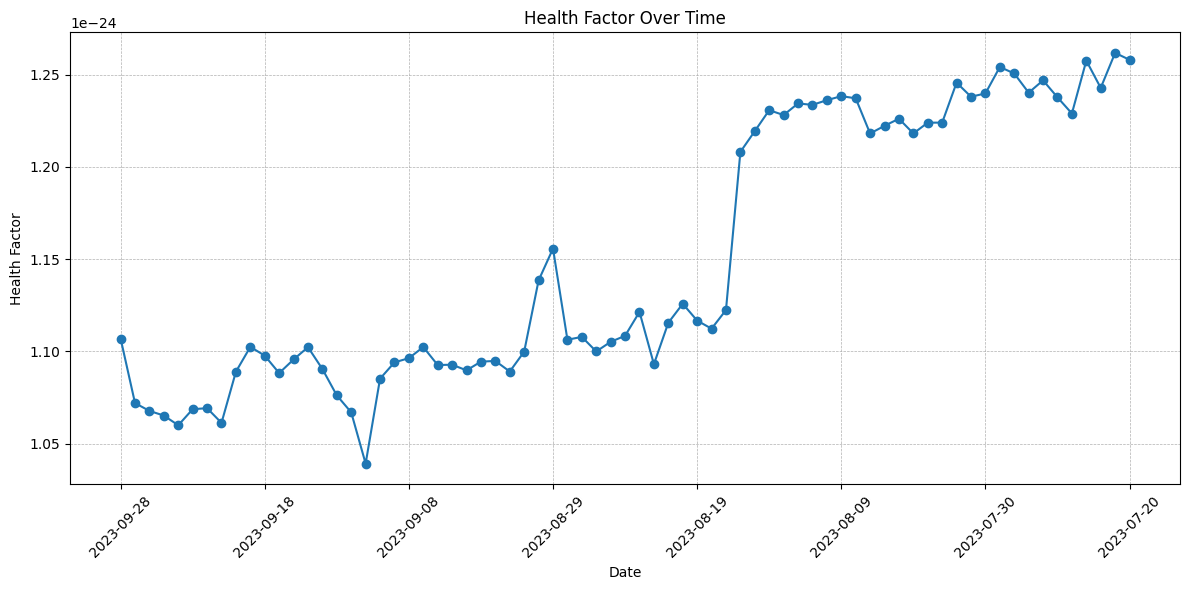

In [20]:
result_df = simulator.compute_health_factor_over_time(test_date, 1, usdc_amount)

simulator.plot_health_factor(result_df)


# Rewards over time

In [21]:
rewards = simulator.rewards_per_date(test_date)
print(rewards)

{}


# Health Factor Over time reinvesting 500 usdc worth of wstETH when hf is down 15%

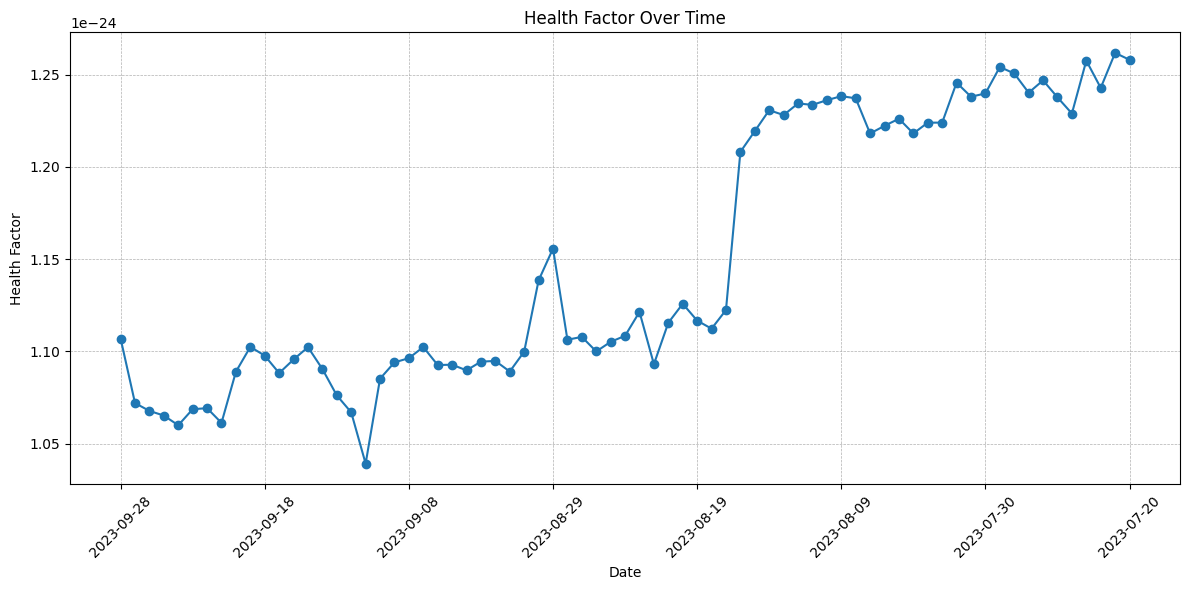

In [22]:
result_df = simulator.simulate_reinvest(test_date, 1, usdc_amount)
simulator.plot_health_factor(result_df)

# Health Factor Over time reinvesting rewards when hf down 15%

0     0
1     0
2     0
3     0
4     0
     ..
66    0
67    0
68    0
69    0
70    0
Name: wstETH Deposited from Rewards, Length: 71, dtype: int64


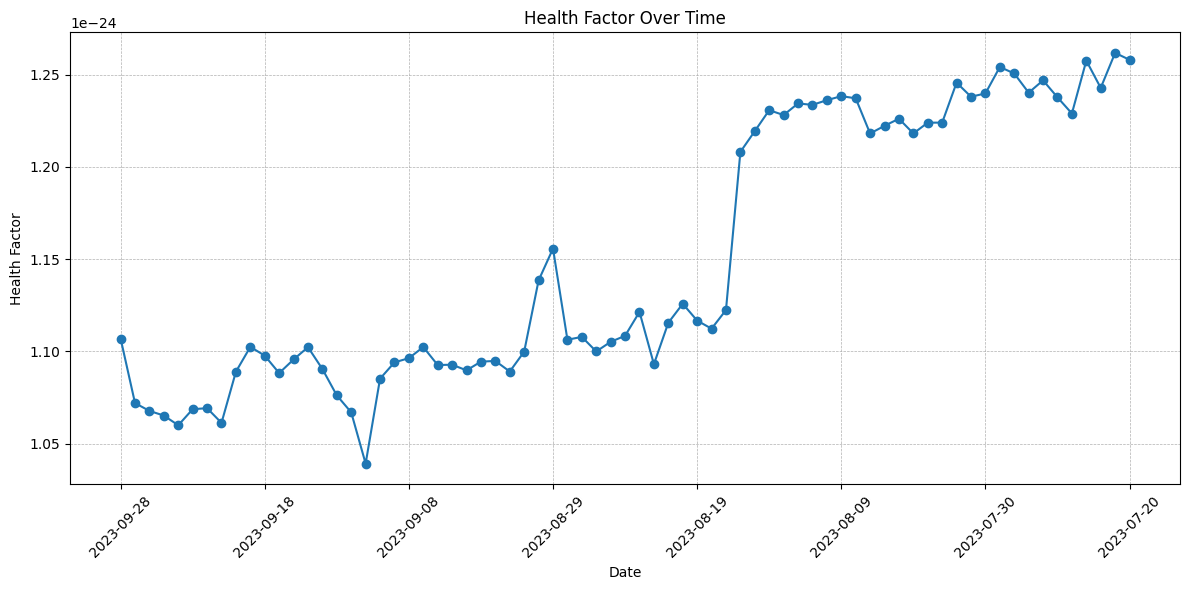

In [23]:
result_df = simulator.simulate_reinvestV2(test_date, 1, usdc_amount,rewards)
print(result_df['wstETH Deposited from Rewards'])
simulator.plot_health_factor(result_df)

# Profitability of just the wsteth position

simulator.plot_wsteth_profitability_usd2('2023-09-24', '2023-09-28')

# Profitability of the wsteth position and rewards

In [24]:
simulator.plot_wsteth_profitability_usd_with_rewards(test_date, end_date, rewards)

,converted_date,profitability_usd
0,2023-07-30,0.000000
1,2023-07-29,24.366935
2,2023-07-28,18.398264
3,2023-07-27,0.689646
4,2023-07-26,12.040659
5,2023-07-25,-3.606877
6,2023-07-24,-18.493432
7,2023-07-23,30.218160
8,2023-07-22,5.108092
9,2023-07-21,37.369195


# Profitability of the wsteth position and rewards and impermanent loss

/var/folders/7m/v3d_bls57dj9rnfmbzkf3c1h0000gn/T/ipykernel_79804/1625213755.py:466: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d2dpool_balance['d2d_usdc_ratio'] = d2dpool_balance['token1delta'].astype(float) / (d2dpool_balance['token2delta'].astype(float) + 1e-10)  # Avoid division by zero
/var/folders/7m/v3d_bls57dj9rnfmbzkf3c1h0000gn/T/ipykernel_79804/1625213755.py:467: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d2dpool_balance['price_change_d2d'] = d2dpool_balance['d2d_usdc_ratio'] / initial_d2d_us

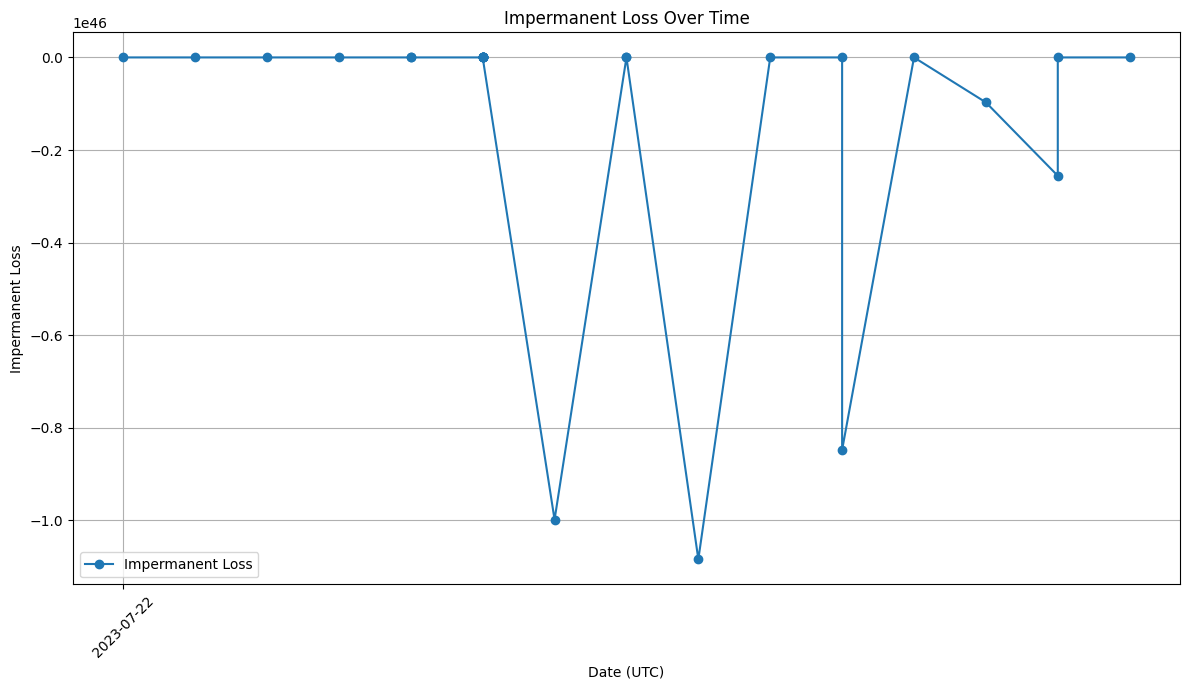

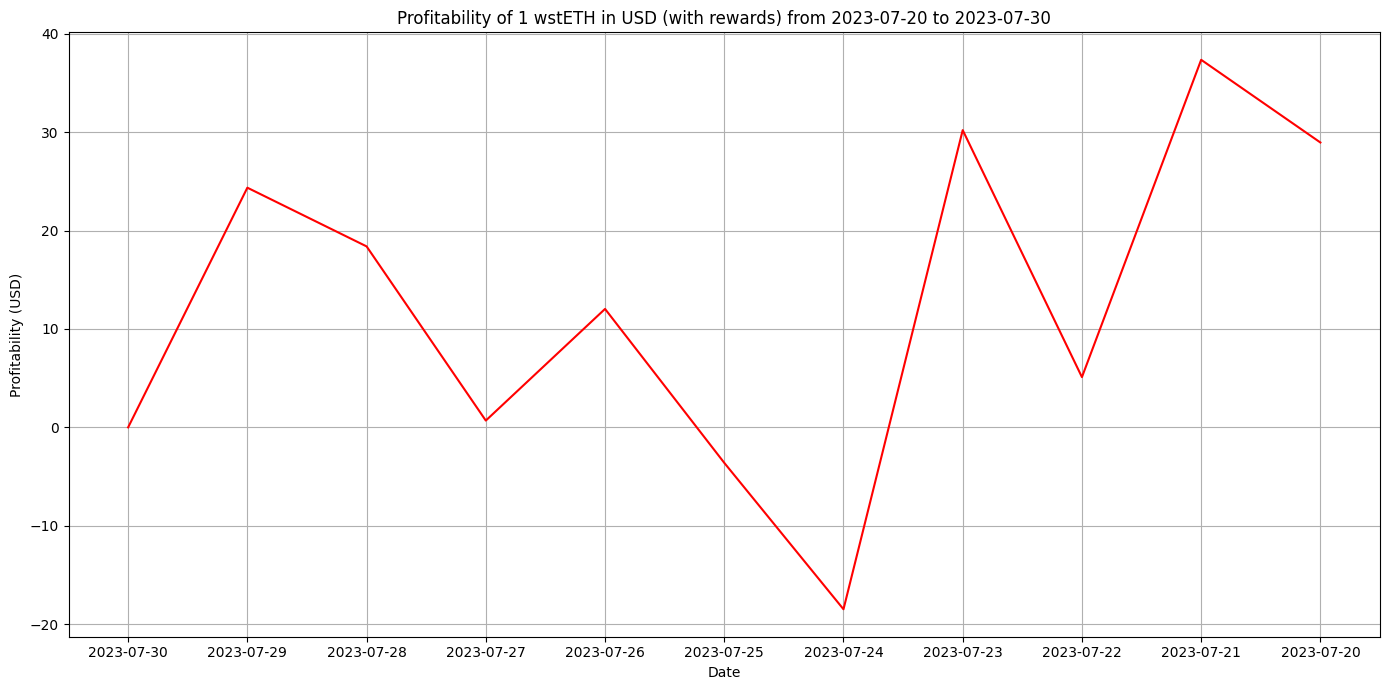

In [25]:
last_day_il_value = simulator.plot_impermanent_loss_with_cleaned_dates_v2(usdc_amount, test_date)
simulator.plot_wsteth_profitability_usd_with_rewards_and_final_impermanent_loss(test_date, end_date, rewards,last_day_il_value )
